In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
import missingno as msno
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier

Using TensorFlow backend.


In [2]:
from sklearn.metrics import precision_score, classification_report,average_precision_score, accuracy_score, balanced_accuracy_score, precision_recall_curve, f1_score, auc, roc_curve

### Original Data

In [3]:
original_data = pd.read_csv('sepsis_data.psv', sep ='|')

In [4]:
original_data.shape

(1361672, 41)

### Training Data

In [5]:
# dropping NA values and removing missing values over 92+ %
training_data = pd.read_csv('fe_train.csv')

In [6]:
training_data.shape

(1361664, 12)

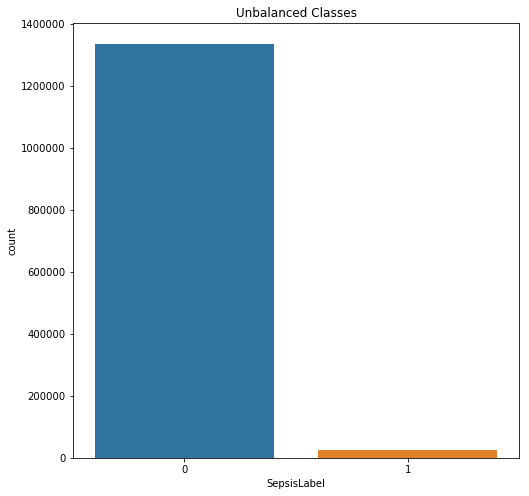

In [7]:
plt.figure(figsize=(8, 8))
sns.countplot('SepsisLabel', data=training_data)
plt.title('Unbalanced Classes')
plt.show()

### Testing data

In [8]:
testing_data = pd.read_csv('fe_test.csv')

In [9]:
testing_data.shape

(190615, 12)

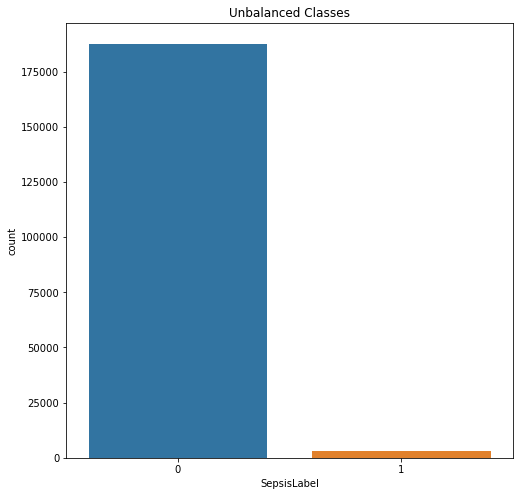

In [10]:
plt.figure(figsize=(8, 8))
sns.countplot('SepsisLabel', data=testing_data)
plt.title('Unbalanced Classes')
plt.show()

### Encoding Training Data

In [11]:
from sklearn.preprocessing import LabelEncoder

In [12]:
le = LabelEncoder()

In [13]:
# Encode training data
for col in training_data.columns.values:
    # Encoding only categorical variables
    if training_data[col].dtypes=='object':
        # Using whole data to form an exhaustive list of levels
        data=training_data[col]
        le.fit(data.values)
        training_data[col]=le.transform(training_data[col])
       

In [14]:
training_data.head()

,Gender,new_age,new_o2sat,new_temp,new_bp,new_resp,new_map,new_fio2,new_hr,HospAdmTime,ICULOS,SepsisLabel
0,0,1,1,0,0,1,0,0,0,-0.03,1,0
1,0,1,2,0,0,2,2,0,0,-0.03,2,0
2,0,1,2,0,0,0,2,0,0,-0.03,3,0
3,0,1,2,0,0,0,0,0,0,-0.03,4,0
4,0,1,0,0,0,0,2,2,1,-0.03,5,0


### Encoding testing data

In [15]:
# Encode training data
for col in testing_data.columns.values:
    # Encoding only categorical variables
    if testing_data[col].dtypes=='object':
        # Using whole data to form an exhaustive list of levels
        data=testing_data[col]
        le.fit(data.values)
        testing_data[col]=le.transform(testing_data[col])
       

In [16]:
testing_data.head()

,Gender,new_age,new_o2sat,new_temp,new_bp,new_resp,new_map,new_fio2,new_hr,HospAdmTime,ICULOS,SepsisLabel
0,1,1,1,0,0,1,0,0,0,-43.69,1,0
1,1,1,2,0,0,1,1,0,0,-43.69,2,0
2,1,1,2,2,0,1,1,0,0,-43.69,3,0
3,1,1,2,0,0,1,1,0,0,-43.69,4,0
4,1,1,2,2,0,1,2,0,0,-43.69,5,0


### Seggregating Training and Testing Data

In [17]:
cols = ['Gender', 'new_age', 'new_o2sat', 'new_temp', 'new_bp', 'new_resp', 'new_map', 'new_fio2', 'new_hr', 'HospAdmTime', 'ICULOS']

X_train = training_data[cols]
y_train = training_data['SepsisLabel']

In [18]:
X_test = testing_data[cols]
y_test = testing_data['SepsisLabel']

### Version 1

### Using Balanced Bagging Classifer using Decision Tree Classifer

In [19]:
#Create an object of the classifier.

bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)

In [20]:
# Train the classifier

bbc.fit(X_train, y_train)

BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                criterion='gini',
                                                                max_depth=None,
                                                                max_features=None,
                                                                max_leaf_nodes=None,
                                                                min_impurity_decrease=0.0,
                                                                min_impurity_split=None,
                                                                min_samples_leaf=1,
                                                                min_samples_split=2,
                                                                min_weight_fraction_leaf=0.0,
                                                                presort=False,
                                                                r

In [ ]:
# predict class values
dt_pred = bbc.predict(X_test)
dt_pred.sum()

In [ ]:
y_test

In [ ]:
balanced_accuracy_score(y_train, dt_pred)

In [ ]:
# predict probabilities
dt_prob = bbc.predict_proba(X_test)

In [ ]:
# keep probabilities for the positive outcome only
dt_prob = dt_prob[:, 1]

### Getting Precision, Recall, F1 score, AUC

In [ ]:
dt_precision, dt_recall, _ = precision_recall_curve(y_test, dt_prob)
dt_f1, dt_auc = f1_score(y_test, dt_pred), auc(dt_recall, dt_precision)

In [ ]:
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (dt_f1, dt_auc))

In [ ]:
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(dt_recall, dt_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
fpr, tpr, _ = roc_curve(y_test, dt_pred)

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') #center line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Version 2

### Training with a XGB Classifer

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb_model = XGBClassifier(learning_rate=0.05, n_estimators=300, max=5)

In [ ]:
xgb_model.fit(X_train, y_train)

In [ ]:
pred_xgb = xgb_model.predict(X_test)

In [ ]:
predictions = [round(value) for value in pred_xgb]

accuracy = balanced_accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

### Training with Balanced Bagging Classifer

In [ ]:
### Training with balanced bagging classifer

bbc_xgb = BalancedBaggingClassifier(base_estimator=XGBClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)

In [ ]:
bbc_xgb.fit(X_train, y_train)

In [ ]:
preds_xgb = bbc.predict(X_test)

In [ ]:
accuracy_score(y_test, preds_xgb)
#accuracy_score(y_train,preds_xgb)

In [ ]:
# Predict probabilities
xgb_prob = bbc_xgb.predict_proba(X_test)
xgb_prob

In [ ]:
# keep probabilities for the positive outcome only
xgb_prob = xgb_prob[:, 1]


In [ ]:
# Get precision, recall values
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, preds_xgb)
xgb_f1, xgb_auc = f1_score(y_test, preds_xgb), auc(xgb_recall, xgb_precision)

In [ ]:
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (xgb_f1, xgb_auc))

In [ ]:
fpr, tpr, _ = roc_curve(y_test, preds_xgb)

In [ ]:
### ROC

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') #center line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
### P-R Curve

In [ ]:
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(xgb_recall, xgb_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
average_precision = average_precision_score(y_test, pred_xgb)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

### Version 3

### Using Pipeline

In [13]:
target_names = ['No Sepsis', 'Sepsis']

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [16]:
def plot_PR(y_test, y_score):
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    average_precision = average_precision_score(y_test, y_score)
    
    plt.figure()
    lw = 2
    #plt.plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    plt.fill_between(recall, precision, alpha=0.2, color='darkorange', **step_kwargs)
    plt.step(recall, precision, color='darkorange', where='post', 
             lw=lw, label='PR curve (average precision = %0.2f)' % average_precision)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision Recall curve')
    plt.legend(loc="lower right")
    plt.show()


In [17]:
def plot_ROC(y_test, y_score, n_classes=2):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr['positive'], tpr['positive'], _ = roc_curve(y_test, y_score)
    roc_auc['positive'] = auc(fpr['positive'], tpr['positive'])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.figure()
    lw = 2
    plt.plot(fpr['positive'], tpr['positive'], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc['positive'])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()

In [18]:
def plot_AUC(y_test, y_score):
    plot_ROC(y_test, y_score)
    plot_PR(y_test, y_score)

In [19]:
def fit_predict(model, X, Y, X_test, Y_test, target_names, verbose=True):
    model.fit(X, Y)
    
    if verbose:
        print('='*20 + 'train' + '='*20 )
        Y_pred = model.predict(X)    
        print(classification_report(Y, Y_pred, target_names=target_names))

        print('='*20 + 'test' + '='*20 )
        Y_pred = model.predict(X_test) 
        print(classification_report(Y_test, Y_pred, target_names=target_names))
    
    try:
        print(model.named_steps['clf'].best_params_)
    except: 
        pass
    print('')
    
    try:
        plot_AUC(Y_test, model.decision_function(X_test))
    except AttributeError:
        pass
    
    accuracy, precision, recall = accuracy_score(Y_test, Y_pred), precision_score(Y_test, Y_pred), recall_score(Y_test, Y_pred)
    print('accuracy', 'precision', 'recall', sep='\t')
    print('{:.6f}\t{:.6f}\t{:.6f}\n'.format(accuracy, precision, recall))

In [20]:
model = Pipeline([#('select', VarianceThreshold()),
                  ('scale', StandardScaler()),
                  ('poly', PolynomialFeatures()),
                  ('clf', GaussianNB())])

In [ ]:
fit_predict(model, X_train, y_train, X_test, y_test, target_names=['no sepis', 'sepsis'])

In [21]:
from sklearn.metrics import recall_score

In [23]:
model.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('poly',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('clf', GaussianNB(priors=None, var_smoothing=1e-09))],
         verbose=False)

In [30]:
Y_pred_train = model.predict(X_train)
Y_pred_test = model.predict(X_test)


In [35]:
y_score = model.predict_proba(X_test)


190614.99999999994